In [92]:
import os
if os.getcwd().replace("\\", "/").split("/")[-1] in ["notebooks", "scripts"]:
    os.chdir("..")

In [93]:
import duckdb
import pandas as pd
import numpy as np
from time import time

In [94]:
import duckdb
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [95]:
con = duckdb.connect('data/exploitation.db')
df = con.execute("select * from sandbox_T_apartment_S_ca_preprocessed").df()

In [96]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# select columns
y_col = 'price'
x_cols_binary = ['cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished']
x_cols_numeric = [
    'sqfeet', 'beds', 'baths','lat', 'long','num_hospitals', 'num_beds', 'hospital_type_general', 'hospital_type_critical',
    'hospital_type_psychiatric', 'hospital_type_longterm', 'hospital_type_children','government_hospital', 'nonprofit_hospital',
    'num_schools', 'num_students', 'preschool', 'elementary_school', 'middle_school', 'high_school'
]
x_cols_onehot = ['type', 'state']

In [97]:
# make everything numeric and scaled
bin2num = lambda x: 1 if x=='Yes' or x==1 else 0
for col in x_cols_binary:
    df[col] = df[col].apply(bin2num)

# one-hot encoding in categorical variables
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[x_cols_onehot])

cols_encoded = []
for i in range(len(x_cols_onehot)):
  col = x_cols_onehot[i]
  print("col: ", col)
  for name in enc.categories_[i]:
    cols_encoded.append(str(col+'_'+name[0:].strip()).lower().strip())
    print("name: ", str(col+'_'+name[0:].strip()).lower().strip())

df_onehot_encoded = pd.DataFrame(enc.transform(df[x_cols_onehot]).toarray(), columns = cols_encoded)

# scaling numerical variables:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[x_cols_numeric]), columns = x_cols_numeric)



col:  type
name:  type_apartment
col:  state
name:  state_ca


In [98]:
# columns in the one-hot encoding
print(enc.feature_names_in_)
print(enc.categories_)

# parameters used in the scaling
print(scaler.feature_names_in_)
print(scaler.mean_)
print(scaler.scale_)

['type' 'state']
[array(['apartment'], dtype=object), array(['ca'], dtype=object)]
['sqfeet' 'beds' 'baths' 'lat' 'long' 'num_hospitals' 'num_beds'
 'hospital_type_general' 'hospital_type_critical'
 'hospital_type_psychiatric' 'hospital_type_longterm'
 'hospital_type_children' 'government_hospital' 'nonprofit_hospital'
 'num_schools' 'num_students' 'preschool' 'elementary_school'
 'middle_school' 'high_school']
[ 6.74350254e+00  1.65000537e+00  1.42874932e+00  3.59047598e+01
 -1.19466540e+02  1.30666495e+03  1.13283545e+01  5.89269893e+00
  0.00000000e+00  3.98172122e+00  1.72859970e+00  1.49842458e+00
  4.46653394e+00  5.39052612e+00  2.40204982e+04  1.55558872e+01
  8.53442545e+00  7.10470869e+00  7.45915720e+00  6.18672391e+00]
[2.87982176e-01 7.41953886e-01 5.09257407e-01 2.12147023e+00
 1.81373404e+00 1.81885384e+03 1.64890268e+00 1.61495085e+00
 1.00000000e+00 1.77727419e+00 1.98177193e+00 1.79543624e+00
 1.61221055e+00 1.63133903e+00 3.29609171e+04 1.64351897e+00
 1.60979527e+00

In [99]:
df_processed = pd.concat(objs=[
    df[x_cols_binary], df_onehot_encoded, df_scaled, df[[y_col]]
], axis = 1
)

df_processed.fillna(0, inplace=True)

df_processed.head()

,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,type_apartment,state_ca,sqfeet,beds,...,hospital_type_children,government_hospital,nonprofit_hospital,num_schools,num_students,preschool,elementary_school,middle_school,high_school,price
0,0,0,1,0,0,0,1.0,1.0,0.604909,0.47172,...,-0.834574,-1.407576,-1.027962,-0.683613,-0.949014,-1.067024,-0.904999,-1.217061,-1.620119,6.928538
1,1,1,1,0,0,0,1.0,1.0,0.006021,0.47172,...,-0.834574,0.385224,0.909481,0.297003,0.938886,0.854359,1.032186,0.760267,0.414015,6.883463
2,1,1,1,0,0,0,1.0,1.0,0.006021,0.47172,...,-0.834574,0.385224,0.909481,0.297003,0.938886,0.854359,1.032186,0.760267,0.414015,6.883463
3,1,1,1,0,0,0,1.0,1.0,0.006021,0.47172,...,-0.834574,0.385224,0.909481,0.297003,0.938886,0.854359,1.032186,0.760267,0.414015,6.883463
4,0,0,1,0,0,0,1.0,1.0,-0.114519,0.47172,...,-0.834574,-0.799201,-0.390437,-0.596874,-0.298045,-0.406027,-0.241929,-0.528018,-0.996157,6.923629


In [100]:
# split training set and test set and validation set
df_train, df_val, df_test = np.split(
    df_processed.sample(frac=1, random_state=777),
    [ int(0.6*len(df_processed)) , int(0.8*len(df_processed)) ]
    )

X_train = df_train.drop(y_col, axis=1).sample(round(len(df)*0.05), random_state=777).to_numpy()
y_train = df_train[y_col].sample(round(len(df)*0.05), random_state=777).to_numpy()
X_val = df_val.drop(y_col, axis=1).to_numpy()
y_val = df_val[y_col].to_numpy()
X_test = df_test.drop(y_col, axis=1).to_numpy()
y_test = df_test[y_col].to_numpy()

# Feature Selection

In [101]:
import scipy.io
from skfeature.function.similarity_based import fisher_score
#from skfeature.function.wrapper import decision_tree_backward # Not work
#from skfeature.function.wrapper import svm_backward # Not work
from skfeature.function.information_theoretical_based.CIFE import cife


In [102]:
tic = time()
score = fisher_score.fisher_score(X_train, y_train)
toc = time()

print(f"Done in {toc - tic:.3f}s")

#score_dc = decision_tree_backward(X_train, y_train,10)
#score_svm = svm_backward.svm_backward(X_train, y_train,15)

tic = time()
(best_cife,_,coef_cife) = cife(X_train, y_train)
toc = time()

print(f"Done in {toc - tic:.3f}s")

Done in 2.178s
Done in 0.529s


In [103]:
best_cife

array([23,  8,  6,  7, 16,  1])

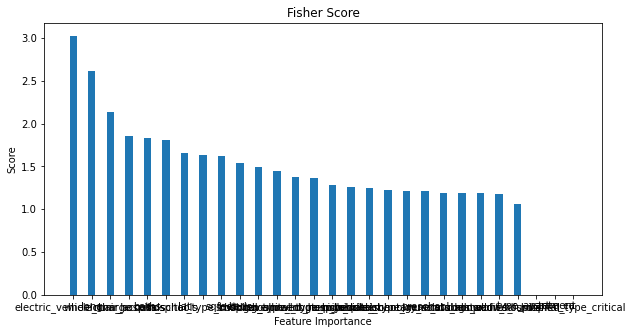

In [104]:
name_columns = list(df_processed.drop(y_col, axis=1).columns)
named_score = [(name_columns[i],score[i]) for i in range(len(score))]

named_score.sort(key=lambda a: a[1], reverse=True)
key = [a for (a,_) in named_score]
value = [b for (_,b) in named_score]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(key, value, width = 0.4)
 
plt.xlabel("Feature Importance")
plt.ylabel("Score")
plt.title("Fisher Score")
plt.show()

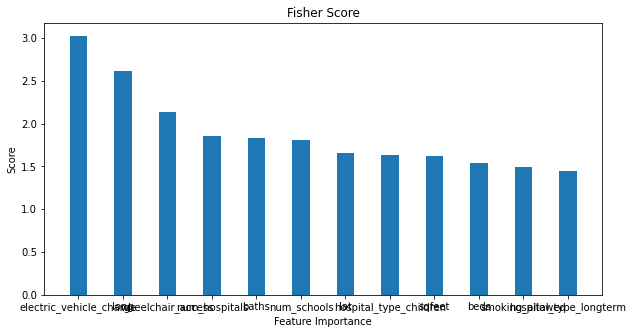

In [105]:
threshold = np.mean(score)
key_important = [a for (a,b) in named_score if b >= threshold]
value_important = [b for (_,b) in named_score if b >= threshold]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(key_important, value_important, width = 0.4)
 
plt.xlabel("Feature Importance")
plt.ylabel("Score")
plt.title("Fisher Score")
plt.show()

In [106]:
my_cols = [name_columns[i] for i in best_cife]
my_cols

['num_students',
 'sqfeet',
 'type_apartment',
 'state_ca',
 'hospital_type_critical',
 'dogs_allowed']

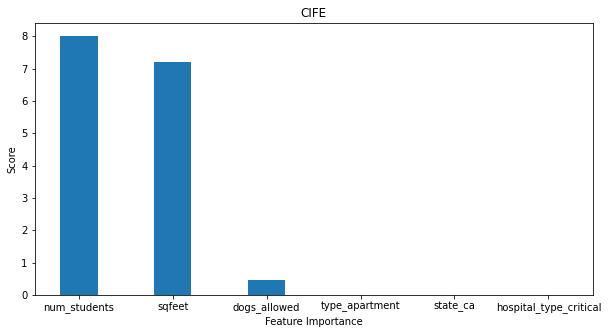

In [107]:
name_columns = list(df_processed.drop(y_col, axis=1).columns)
named_cife = [(name_columns[best_cife[i]],coef_cife[i]) for i in range(len(best_cife))]

named_cife.sort(key=lambda a: a[1], reverse=True)
feature_cife = [a for (a,_) in named_cife]
value = [b for (_,b) in named_cife]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(feature_cife, value, width = 0.4)
 
plt.xlabel("Feature Importance")
plt.ylabel("Score")
plt.title("CIFE")
plt.show()

In [108]:
named_cife

[('num_students', 8.004914758096714),
 ('sqfeet', 7.189191703198702),
 ('dogs_allowed', 0.471485811799079),
 ('type_apartment', 0.0),
 ('state_ca', 0.0),
 ('hospital_type_critical', 0.0)]

In [109]:
from sklearn.ensemble import RandomForestRegressor
tic = time()
rf = RandomForestRegressor(oob_score=True,random_state=40).fit(X_train, y_train)
toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 0.869s


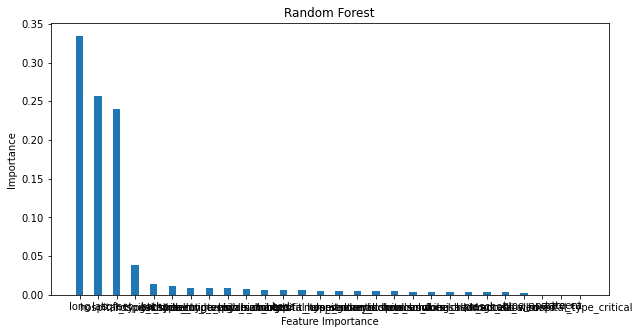

In [110]:
named_rf = [(name_columns[i],rf.feature_importances_[i]) for i in range(len(name_columns))]
named_rf.sort(key=lambda a: a[1], reverse=True)
key_important = [a for (a,b) in named_rf]
value_important = [b for (_,b) in named_rf]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(key_important, value_important, width = 0.4)
 
plt.xlabel("Feature Importance")
plt.ylabel("Importance")
plt.title("Random Forest")
plt.show()

In [111]:
from sklearn.feature_selection import SelectFromModel
threshold = np.mean(rf.feature_importances_)
sfm = SelectFromModel(rf, threshold=threshold).fit(X_train, y_train)
feature_rf = list(df_processed.drop(y_col, axis=1).columns[sfm.get_support()])
print(feature_rf)

['sqfeet', 'lat', 'long', 'hospital_type_children']


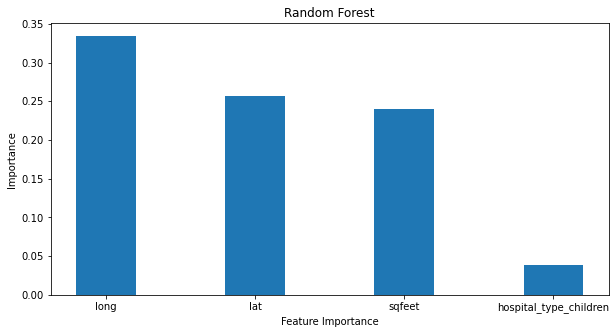

In [112]:
named_rf = [(name_columns[i],rf.feature_importances_[i]) for i in range(len(name_columns))]
named_rf.sort(key=lambda a: a[1], reverse=True)
feature_rf = [a for (a,b) in named_rf if b > threshold]
value_important = [b for (_,b) in named_rf if b > threshold]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(feature_rf, value_important, width = 0.4)
 
plt.xlabel("Feature Importance")
plt.ylabel("Importance")
plt.title("Random Forest")
plt.show()

In [113]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [114]:
def printMetrics(y_true, y_pred):
    print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print("MAE: ", metrics.mean_absolute_error(y_true, y_pred))
    print("MAPE: ", metrics.mean_absolute_percentage_error(y_true, y_pred))
    print("R2: ", metrics.r2_score(y_true, y_pred))
    print()

In [115]:
id_fisher = [i for i in range(len(score)) if score[i] > 1]
id_cife = list(best_cife)
id_rf = [i for i in range(len(rf.feature_importances_)) if rf.feature_importances_[i] > threshold]


X_train = df_train.drop(y_col, axis=1).to_numpy()
y_train = df_train[y_col].to_numpy()

X_train_fs, X_val_fs = X_train[:,id_fisher], X_val[:,id_fisher]
X_train_cife, X_val_cife = X_train[:,id_cife], X_val[:,id_cife]
X_train_rf, X_val_rf = X_train[:,id_rf], X_val[:,id_rf]

print(np.shape(X_train))
print(np.shape(X_train_fs))
print(np.shape(X_train_cife))
print(np.shape(X_train_rf))

(16072, 28)
(16072, 25)
(16072, 6)
(16072, 4)


In [116]:
print(np.shape(X_val))
print(np.shape(X_val_fs))
print(np.shape(X_val_cife))
print(np.shape(X_val_rf))

(5357, 28)
(5357, 25)
(5357, 6)
(5357, 4)


# Test Models

In [117]:
tic = time()
reg = LinearRegression().fit(X_train, y_train)
toc = time()

print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))
print(f"Done in {toc - tic:.3f}s")


0.6596438920219878
0.5502286487726277
Done in 0.011s


In [118]:
tic = time()
reg = LinearRegression().fit(X_train_fs, y_train)
toc = time()

print(reg.score(X_train_fs, y_train))
print(reg.score(X_val_fs, y_val))
print(f"Done in {toc - tic:.3f}s")

0.6596438920219878
0.6793477112936634
Done in 0.008s


In [119]:
tic = time()
reg = LinearRegression().fit(X_train_cife, y_train)
toc = time()

print(reg.score(X_train_cife, y_train))
print(reg.score(X_val_cife, y_val))
print(f"Done in {toc - tic:.3f}s")

0.1413330650984791
0.1364604237676842
Done in 0.004s


In [120]:
tic = time()
reg = LinearRegression().fit(X_train_rf, y_train)
toc = time()

print(reg.score(X_train_rf, y_train))
print(reg.score(X_val_rf, y_val))
print(f"Done in {toc - tic:.3f}s")

0.42084679984567963
0.4486501387565671
Done in 0.004s


# Random Forest

In [121]:
tic = time()
rf = RandomForestRegressor(oob_score=True).fit(X_train, y_train)
toc = time()

yhat_train = rf.predict(X_train)
yhat_val = rf.predict(X_val)

printMetrics(y_train, yhat_train)
printMetrics(y_val, yhat_val)
print(f"Done in {toc - tic:.3f}s")

RMSE:  0.04347660880101799
MAE:  0.02279380208921643
MAPE:  0.0030605574844259284
R2:  0.9862126594596796

RMSE:  0.09726272927634279
MAE:  0.04637826360278696
MAPE:  0.0062416335128430405
R2:  0.930120453205665

Done in 9.109s


In [122]:
tic = time()
rf = RandomForestRegressor(oob_score=True).fit(X_train_fs, y_train)
toc = time()

yhat_train_fs = rf.predict(X_train_fs)
yhat_val_fs = rf.predict(X_val_fs)

printMetrics(y_train, yhat_train_fs)
printMetrics(y_val, yhat_val_fs)
print(f"Done in {toc - tic:.3f}s")

RMSE:  0.043248426122449696
MAE:  0.02274072843045703
MAPE:  0.0030544106649560295
R2:  0.986357002662233

RMSE:  0.09691163696136734
MAE:  0.046512846031768355
MAPE:  0.006259349129638468
R2:  0.9306240354339665

Done in 8.925s


In [123]:
tic = time()
rf = RandomForestRegressor(oob_score=True).fit(X_train_cife, y_train)
toc = time()

yhat_train_cife = rf.predict(X_train_cife)
yhat_val_cife = rf.predict(X_val_cife)

printMetrics(y_train, yhat_train_cife)
printMetrics(y_val, yhat_val_cife)
print(f"Done in {toc - tic:.3f}s")

RMSE:  0.0795028422392422
MAE:  0.04432008778528638
MAPE:  0.005920198017763095
R2:  0.9538964370518332

RMSE:  0.20486538731243029
MAE:  0.10453718228673747
MAPE:  0.013980886241015443
R2:  0.6899766864410161

Done in 2.090s


In [124]:
tic = time()
rf = RandomForestRegressor(oob_score=True).fit(X_train_rf, y_train)
toc = time()

yhat_train_rf = rf.predict(X_train_rf)
yhat_val_rf = rf.predict(X_val_rf)

printMetrics(y_train, yhat_train_rf)
printMetrics(y_val, yhat_val_rf)
print(f"Done in {toc - tic:.3f}s")

RMSE:  0.045483603545996946
MAE:  0.023993423661139542
MAPE:  0.0032235343192811975
R2:  0.9849103589043199

RMSE:  0.1004161526371952
MAE:  0.04773024670446017
MAPE:  0.006425762435412803
R2:  0.925515770262138

Done in 2.357s


In [125]:
con = duckdb.connect('data/exploitation.db')
con.execute("show tables").fetchall()

[('houses',),
 ('sandbox',),
 ('sandbox_T_apartment_S_ca',),
 ('sandbox_T_apartment_S_ca_preprocessed',),
 ('sandbox_T_apartment_S_ca_preprocessed_reduced',),
 ('sandbox_T_apartment_S_ca_reduced',),
 ('sandbox_preprocessed',)]

In [126]:
df = con.execute("select * from sandbox_T_apartment_S_ca_preprocessed").df()
df.head().transpose()

,0,1,2,3,4
region,bakersfield,bakersfield,bakersfield,bakersfield,bakersfield
price,6.928538,6.883463,6.883463,6.883463,6.923629
type,apartment,apartment,apartment,apartment,apartment
sqfeet,6.917706,6.745236,6.745236,6.745236,6.710523
beds,2.0,2.0,2.0,2.0,2.0
baths,1.0,1.0,1.0,1.0,1.0
cats_allowed,No,Yes,Yes,Yes,No
dogs_allowed,No,Yes,Yes,Yes,No
smoking_allowed,Yes,Yes,Yes,Yes,Yes
wheelchair_access,No,No,No,No,No


In [127]:
df = con.execute("select * from sandbox_T_apartment_S_ca_reduced").df()
df.head().transpose()

,0,1,2,3,4
b_hospital_type_children,0.000000,0.000000,0.000000,0.000000,0.000000
laundry_options w/d in unit,0.000000,0.000000,0.000000,0.000000,0.000000
sqfeet,6.917706,6.745236,6.745236,6.745236,6.710523
lat,35.326300,35.441800,35.441800,35.441800,35.336100
long,-119.074000,-119.030000,-119.030000,-119.030000,-119.081000
hospital_type_children,0.000000,0.000000,0.000000,0.000000,0.000000
price,6.928538,6.883463,6.883463,6.883463,6.923629


In [128]:
con.close()